# TempSAL Inference Notebook

This notebook includes the code to load and test the TempSAL model.
Download the checkpoints from :
https://drive.google.com/drive/folders/1W92oXYra_OPYkR1W56D80iDexWIR7f7Z?usp=sharing<br>
Place them under the "checkpoints" folder. The folder structure should be as follows:

src
>  inference.ipynb <br>
>  checkpoints<br>
>  testing<br>
> > images<br>
> > predictions<br>
> > gt<br>
         

In [ ]:
# Import packages
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import torch.nn as nn
from torchvision.utils import save_image

def to_np(tensor):
    return tensor.permute( 1, 2, 0).detach().cpu().numpy()


def plot_side_by_side(img_array, names=[], colormap = "gray"):
# Create a figure and display the image
    num_imgs = len(img_array)
    plt.subplots(1,num_imgs, figsize=(15,5))
    for i in range(1,num_imgs+1):
        plt.subplot(1,num_imgs,i)
        #plt.imshow(img_array[i-1].cpu().squeeze(0).permute(1,2,0).detach().numpy())
        plt.imshow(img_array[i-1], cmap=colormap)
        if len(names)>0:
            plt.title(str(names[i-1]))
    # Show the figure
    plt.show()
    
# Transformations for the input images
img_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])
        ])
gt_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize([0.5],[0.5])
        ])

# Functions to load images
def get_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img_transform(img)
    return img

def get_image_nonorm(img_path):
    img = Image.open(img_path).convert('RGB')
    img = gt_transform(img)
    return img

def get_gt_tensor(img_path):
    img = Image.open(img_path).convert('L')
    img = gt_transform(img)

    return img
                
def load_model(model_checkpoint_path):
    state_dict = torch.load(model_checkpoint_path)
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        if 'module' not in k.split('.')[0]:
            k = 'module.' + k
        else:
            k = k.replace('features.module.', 'module.features.')
        new_state_dict[k] = v
    #     print(k)
    model = nn.DataParallel(model)
    model.load_state_dict(new_state_dict)
    return model
    
# Predict saliency
def predict(image):

    with torch.no_grad():
        fin_pred , temp_pred = model(image) #Image saliency and temporal saliency predictions
        temp_pred = temp_pred.squeeze(0)

    return fin_pred , temp_pred 


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to the model checkpoints
model_checkpoint_path = "./checkpoints/multilevel_tempsal.pt"
time_slices = 5
train_model = 0

from model import PNASBoostedModelMultiLevel
model = PNASBoostedModelMultiLevel(device, model_checkpoint_path, model_checkpoint_path, time_slices, train_model=train_model )    
    
# Load model    
#model = load_model(model_checkpoint_path)
model = model.to(device)
model.eval()


96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864


PNASBoostedModelMultiLevel(
  (linear_upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  (deconv_layer1): Sequential(
    (0): Conv2d(2678, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  )
  (deconv_layer2): Sequential(
    (0): Conv2d(1342, 270, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  )
  (deconv_layer3): Sequential(
    (0): Conv2d(546, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  )
  (deconv_layer4): Sequential(
    (0): Conv2d(198, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
  )
  (deconv_mix): Sequential(
    (0): Conv2d(134, 16, kernel_size=(3, 3), stride=(1

In [3]:
# Provide the paths to the images you want to test
image_name = "COCO_val2014_000000000208"
image_paths = ["./testing/images/"+image_name+ ".jpg"]
gt_paths = ["./testing/gt/"+image_name+ ".png"]
gt_vol_paths = ["./testing/gt/"+image_name+ "_0.png","./testing/gt/"+image_name+ "_1.png","./testing/gt/"+image_name+ "_2.png","./testing/gt/"+image_name+ "_3.png","./testing/gt/"+image_name+ "_4.png" ]

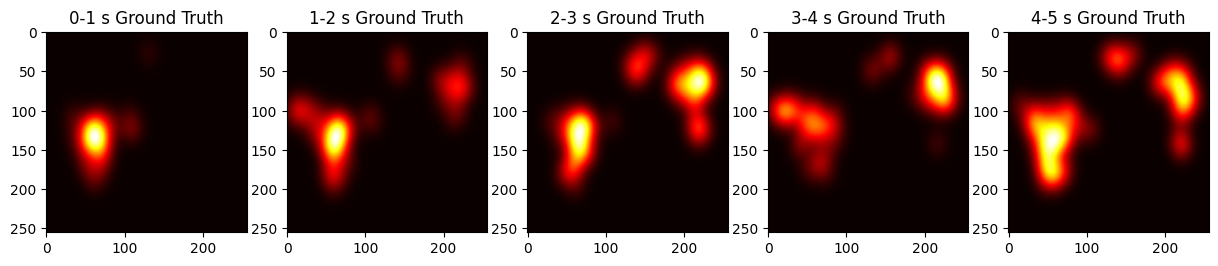

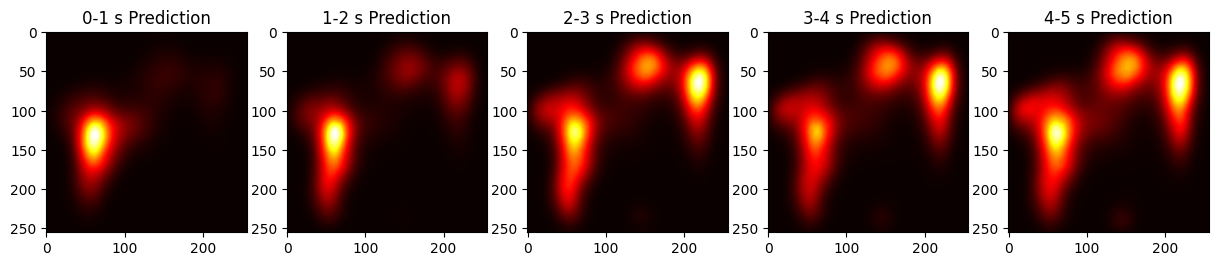

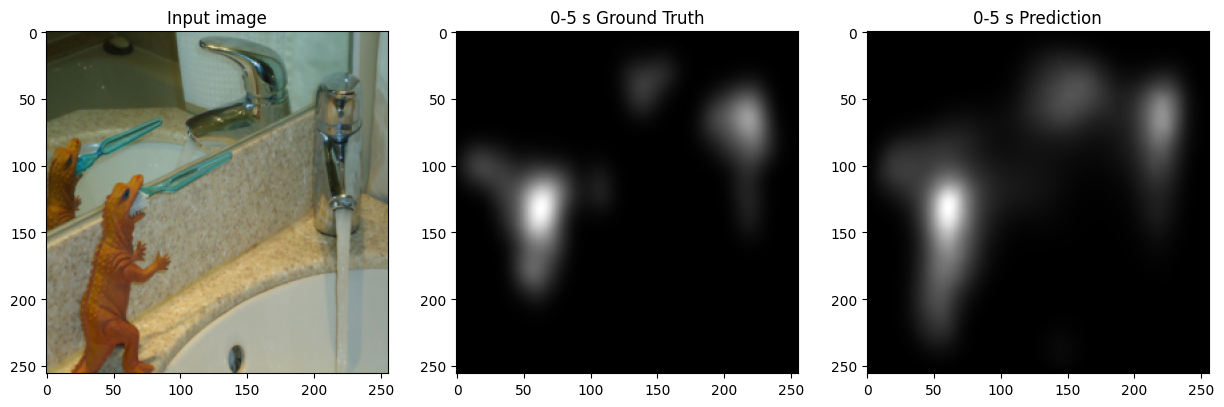

In [4]:
# A prediction with ground truth from SALICON validation dataset
# Loop over the images, make predictions, and display the results
for image_path in image_paths:
    # Read image
    image = get_image(image_path)
    # Predict saliency
    fin_pred , temp_pred  = predict(image.unsqueeze(0))
    temp_pred = temp_pred.unsqueeze(1)
    
    # Display the image and prediction
    #plt.axis("off")
    plot_side_by_side([to_np(get_gt_tensor(gt_vol_paths[0])),to_np(get_gt_tensor(gt_vol_paths[1])),to_np(get_gt_tensor(gt_vol_paths[2])),to_np(get_gt_tensor(gt_vol_paths[3])), to_np(get_gt_tensor(gt_vol_paths[4]))  ], names=["0-1 s Ground Truth", "1-2 s Ground Truth","2-3 s Ground Truth","3-4 s Ground Truth","4-5 s Ground Truth"  ], colormap="hot")    
    plot_side_by_side([to_np(temp_pred[0]),to_np(temp_pred[1]),to_np(temp_pred[2]),to_np(temp_pred[3]),to_np(temp_pred[4]) ], names=["0-1 s Prediction", "1-2 s Prediction","2-3 s Prediction","3-4 s Prediction","4-5 s Prediction" ], colormap="hot")
    plot_side_by_side([to_np(get_image_nonorm(image_path)), to_np(get_gt_tensor(gt_paths[0])), to_np(fin_pred)], names=["Input image", "0-5 s Ground Truth","0-5 s Prediction"], colormap="gray")

    plt.show()



In [5]:
# Save predictions
for idx,p in enumerate(temp_pred):
    save_image(p, './testing/predictions/temporal_saliency_prediction_slice_'+str(idx)+'.png',normalize=True)
save_image(fin_pred, './testing/predictions/image_saliency_prediction.png',normalize=True)
    

In [6]:
# Test your own images
# Provide the paths to the images you want to test
image_paths = ["./testing/images/COCO_val2014_000000000192.jpg"]

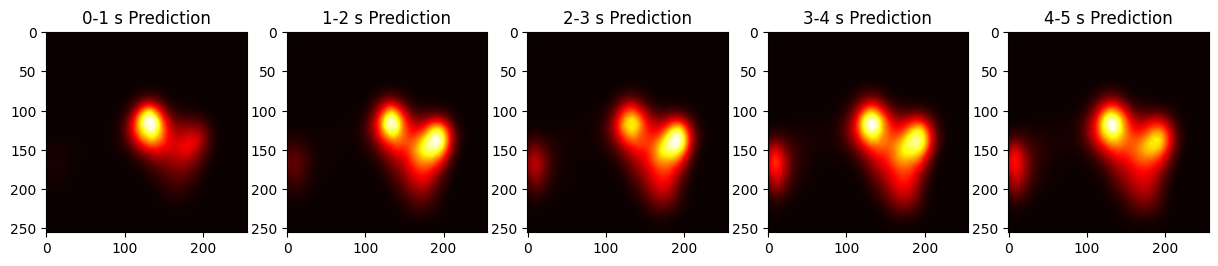

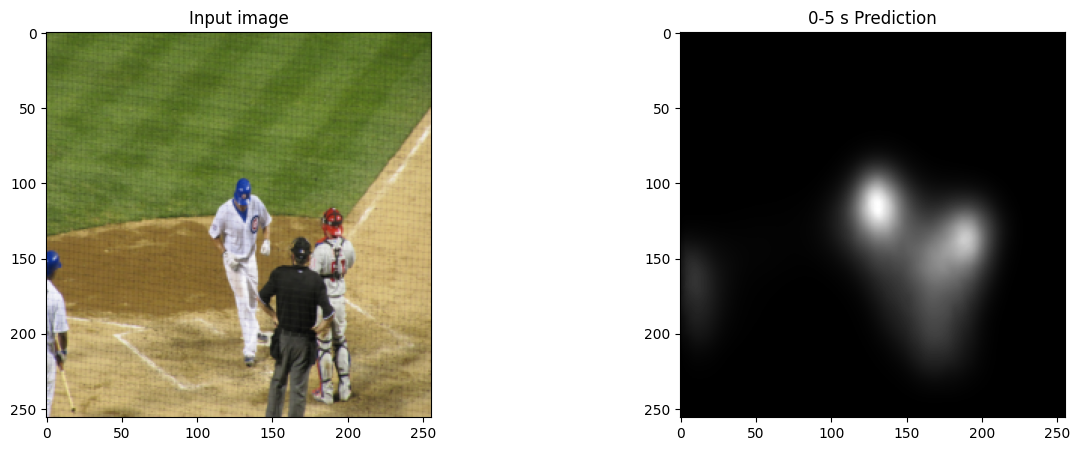

In [7]:
# Loop over the images, make predictions, and display the results
for image_path in image_paths:
    # Read image
    image = get_image(image_path)
    # Predict saliency
    fin_pred , pred_vol  = predict(image.unsqueeze(0))
    pred_vol = pred_vol.unsqueeze(1)

    # Display the image and prediction
    plot_side_by_side([to_np(pred_vol[0]),to_np(pred_vol[1]),to_np(pred_vol[2]),to_np(pred_vol[3]),to_np(pred_vol[4]) ], names=["0-1 s Prediction", "1-2 s Prediction","2-3 s Prediction","3-4 s Prediction","4-5 s Prediction" ], colormap="hot")
    plot_side_by_side([ to_np(get_image_nonorm(image_path)), to_np(fin_pred)], names=["Input image","0-5 s Prediction"], colormap="gray")
    plt.show()

